# WT operating under yaw misalignment

In case the wind turbine rotor is not perpendicular to the inflow, its operation and effects on the flow field will be different. In general it is a quite complicated process. In PyWake the effects are divided into four subeffects that are handled invididually:

1. Change of operation due to reduced inflow wind speed
2. Reduced deficit, <font style="color:red">$deficit_{normal}$</font>, due to reduced inflow wind speed
3. Reduced deficit, <font style="color:#CCCC00">$deficit_{downwind}$</font>, due to misalignment between thrust and downwind direction
4. Deflection of wake deficit, <font style="color:green">$deficit_{deflected}$</font>, due to traversal thrust component reaction

<img src="../_static/wt_in_yaw.svg" alt="drawing" width="700"/>


In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from py_wake.examples.data.hornsrev1 import V80
from py_wake.flow_map import HorizontalGrid
from py_wake.tests.test_files import tfp
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models import FugaYawDeficit
from py_wake.deflection_models import FugaDeflection
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.flow_map import XYGrid


from ipywidgets import interact
from ipywidgets import IntSlider
wt = V80()
site = Hornsrev1Site()

## Change of operation due to reduced inflow wind speed

The inflow perpendicular to the rotor is reduced by $cos\theta$.

This means that the pitch and rotor speed setting of the WT will be different. In PyWake the WT operation (pitch and rotor speed settings) is modeled in terms of the Power and CT curves which must be looked up for the reduced wind speed. 

Note, that below rated rotor speed, the CT curve is typically rather flat and reducing the wind speed has therefore limited effect on the CT value in this region. The power, on the other hand, is limited by the maximum power and therefore only affected in the region below rated wind speed (rated wind speed will increase with yaw misalignment)

Text(0, 0.5, 'Power [W]')

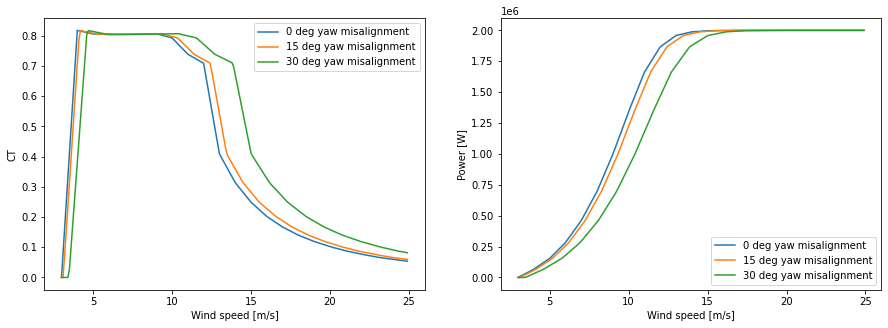

In [3]:
u = np.arange(3,25,.1)
ax1,ax2 = plt.subplots(1,2, figsize=(15,5))[1]
for yaw in [0,15,30]:
    ax1.plot(u,wt.ct(u*np.cos(np.deg2rad(yaw))), label='%d deg yaw misalignment'%yaw)
    ax2.plot(u,wt.power(u*np.cos(np.deg2rad(yaw))), label='%d deg yaw misalignment'%yaw)
for ax in (ax1, ax2):
    ax.legend()
    ax.set_xlabel('Wind speed [m/s]')
ax1.set_ylabel('CT')
ax2.set_ylabel('Power [W]')

Furthermore, misalignemnt between the thrust force (axial induction) and the inflow leads to higher wind speed at the rotor plane which also affects the WT operation. This effect, however, is not considered in PyWake

## Reduced deficit due to reduced inflow wind speed

The wake deficit is caused by a reaction to the thrust force which slows down the inflow.

In non-aligned inflow, the thrust force is reduced as the wind speed component normal to the rotor is reduced

\begin{align}
T & =\frac{1}{2}\rho C_T A (U cos\theta)^2
\end{align}

The engineering models, however, scale their deficit with the inputs, U and CT. The reduction in deficit is therefore modeled by applying a reduced $C_T$ value, $C_{T,yaw}$, that gives the same reduction in thrust, i.e. it satisfies:

\begin{align}
\frac{1}{2}\rho C_{T,yaw} A U^2 & = \frac{1}{2}\rho C_T A (U cos\theta)^2 \\
C_{T,yaw} & = C_T cos^2\theta\\
\end{align}

The `WindTurbines` object is responsible for computing the reduced $C_T$ values and the default model, just multipy the normal ct function value with $cos^2\theta$


## Reduced deficit due to misalignment between thrust and downwind direction

Most engineering models calculate the deficit normal to the rotor plane, while the deficit impacting downstream WT is the deficit in the downstream direction.

In case of yaw misalignment, the deficit is therefore mapped to downstream direction by

$deficit_{downwind} = deficit_{normal} cos \theta$

### FugaYawDeficit

The `FugaYawDeficit` model implicitly models this effect. This model requires two sets of look-up tabels, namely `UL` and `UT`. These tables describes the normalized deficit in the downwind, `U` direction caused by a unit forcing in the longitudinal, `L` and transveral, `T` directions.

In [4]:
fuga = FugaYawDeficit(tfp + 'fuga/2MW/Z0=0.00014617Zi=00399Zeta0=0.00E+0/')
D = 80
R = D/2
x0,x1,y = 1,10,2 #upstream, downstream and crosswind regions to load [D]
xi0 = int(512-x0/(fuga.dx/D))
xi1 = int(512+x1/(fuga.dx/D))+1
yi = int(y/(fuga.dy/D))+1
UL, UT = [fuga.mirror(v,anti_symmetric=a) for v, a in zip(fuga.load_luts()[:2,0,:yi, xi0:xi1], (False,True))]

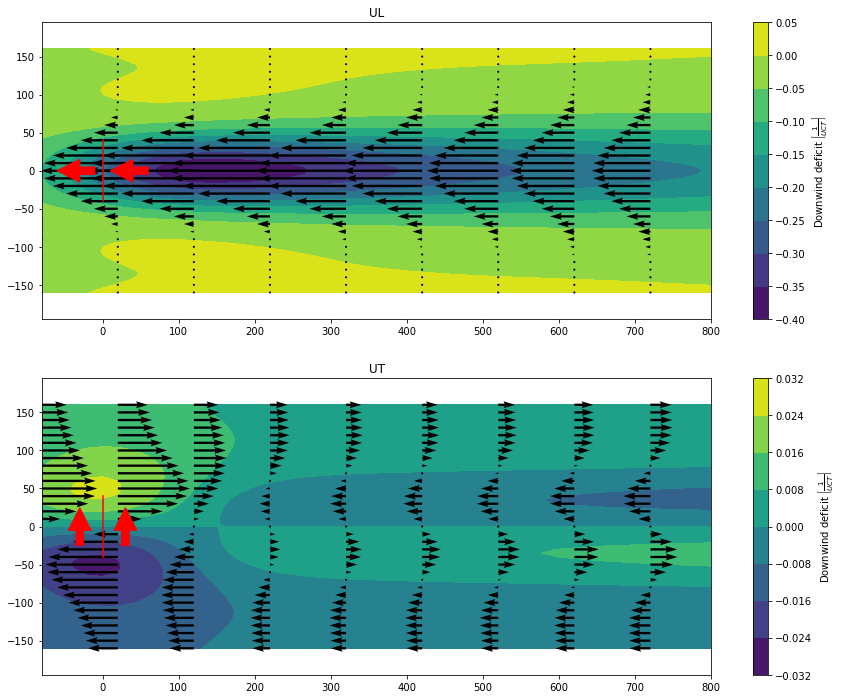

In [5]:
axes = plt.subplots(2,1, figsize=(15,12))[1]
X, Y = np.meshgrid(fuga.x[xi0:xi1], fuga.mirror(fuga.y[:yi], anti_symmetric=True))
wtL = np.array([[0,0],[-D/2,D/2]])
for ax, v, l in zip(axes.flatten(), [UL, UT], ['UL','UT']):
    c = ax.contourf(X, Y, v)
    plt.colorbar(c, ax=ax, label=r'Downwind deficit $\left[\frac{1}{U CT}\right]$')
    s = (slice(None,None,2),slice(None,None,5))
    ax.quiver(X[s], Y[s], v[s]*(l[0]=='U'), v[s]*(l[0]=='V'))
    ax.plot([0,0],[-D/2,D/2],'r')
    if l[1]=='L':
        ax.arrow(-10,0,-20,0,color='r', width=10,head_length=30)
        ax.arrow(60,0,-20,0,color='r', width=10,head_length=30)
    else:
        ax.arrow(-30,-25,0,20,color='r', width=10,head_length=30)
        ax.arrow(30,-25,0,20,color='r', width=10,head_length=30)
        
    ax.axis('equal')
    ax.set_xlim([-D,10*D])
    ax.set_ylim([-D,D])
    ax.set_title(l) 

As Fuga is a linear model, the deficit in the downstream direction can simply be calculated by the linear superposition of `UL` and `UT`:

$deficit = (UL \cdot cos\theta + UT \cdot sin\theta) \cdot U \cdot CT$

You can move the slider below to see the deficit fields for different yaw-misalignment angles


In [6]:
def plot(yaw):
    plt.figure(figsize=(18,5))
    theta = np.deg2rad(yaw)
    co, si = np.cos(theta), np.sin(theta)
    deficit = co**2*(UL*co + UT*si)
    c = plt.contourf(X, Y, deficit, levels=np.arange(-.4,.1,.05))
    plt.colorbar(c, label=r'Downwind deficit $\left[\frac{1}{U CT}\right]$')
    s = (slice(None,None,2),slice(None,None,5))
    plt.quiver(X[s], Y[s], deficit[s], deficit[s]*0, width=.002, scale=2)
    plt.plot([-si*R, si*R],[-co*R,co*R],'w',label='Rotor',lw=3)
    plt.arrow(-0,0,-100*co,0,color='r', width=5,head_length=10,length_includes_head=True)
    plt.arrow(-0,-0,0,100*si,color='r', width=5,head_length=10,length_includes_head=True, zorder=32)
    plt.axis('equal')
    plt.xlim([-D,10*D])
    plt.ylim([-D,D])
    ax.set_title(l) 
_ = interact(plot, yaw=IntSlider(min=-90, max=90, step=1, value=20, continuous_update=False))

interactive(children=(IntSlider(value=20, continuous_update=False, description='yaw', max=90, min=-90), Output…

## Wake deflection due to traversal thrust component reaction

Wake deflection is modeled by a `DeflectionModel` which modifies the downwind, horizontal crosswind and vertical distance between wind turbines. 

### FugaDeflection

FugaDeflection is capable of modeling the wake deflection if the `VL` and `VT` is present. These tables describes the normalized deficit in the crosswind, `V` direction caused by a unit forcing in the longitudinal, `L` and transveral, `T` directions.

In [7]:
fugaDeflection = FugaDeflection(tfp + 'fuga/2MW/Z0=0.00014617Zi=00399Zeta0=0.00E+0/')
D = 80
R = D/2
x0,x1,y = 1,10,2 #upstream, downstream and crosswind regions to load [D]
xi0 = int(512-x0/(fugaDeflection.dx/D))
xi1 = int(512+x1/(fugaDeflection.dx/D))+1
yi = int(y/(fugaDeflection.dy/D))+1

# VL is antisymmetric, VT is symmetric
VL, VT = [fugaDeflection.mirror(v,anti_symmetric=a) for v, a in zip(fugaDeflection.load_luts()[2:4,0,:yi, xi0:xi1], (True, False))]

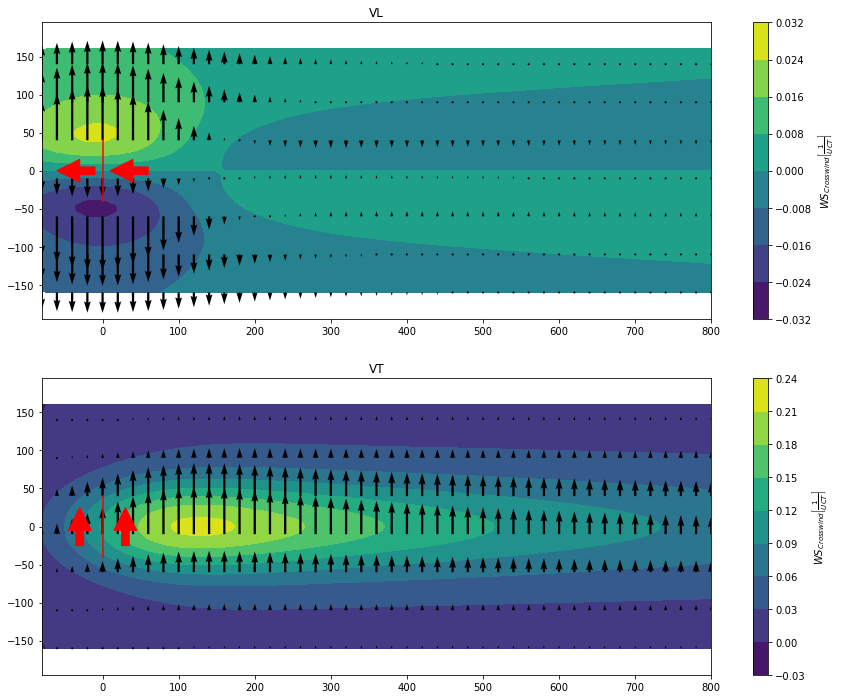

In [8]:
axes = plt.subplots(2,1, figsize=(15,12))[1]
X, Y = np.meshgrid(fugaDeflection.x[xi0:xi1], fugaDeflection.mirror(fugaDeflection.y[:yi], anti_symmetric=True))
for ax, v, l in zip(axes.flatten(), [VL, -VT], ['VL','VT']):
    c = ax.contourf(X, Y, v)
    plt.colorbar(c, ax=ax, label=r'$WS_{Crosswind} \left[\frac{1}{U CT}\right]$')
    s = (slice(None,None,10),slice(None,None,1))
    ax.quiver(X[s], Y[s], 0, v[s], scale=(.3,3)[l[1]=='T'])
    ax.plot([0,0],[-D/2,D/2],'r')
    if l[1]=='L':
        ax.arrow(-10,0,-20,0,color='r', width=10,head_length=30)
        ax.arrow(60,0,-20,0,color='r', width=10,head_length=30)
    else:
        ax.arrow(-30,-25,0,20,color='r', width=10,head_length=30)
        ax.arrow(30,-25,0,20,color='r', width=10,head_length=30)
        
    ax.axis('equal')
    ax.set_xlim([-D,10*D])
    ax.set_ylim([-D,D])
    ax.set_title(l) 

As Fuga is a linear model, the effects in the crosswind direction can simply be calculated by the linear superposition of `VL` and `VT`:

$WS_{crosswind} = cos(VL \cdot cos\theta + VT \cdot sin\theta) \cdot U \cdot CT$

You can move the slider below to see the crosswind wind speed field for different yaw-misalignment angles. Futhermore, the integrated deflection is shown with solid lines

In [9]:
def plot(yaw):
    plt.figure(figsize=(18,5))
    theta = np.deg2rad(yaw)
    co, si = np.cos(theta), np.sin(theta)
    deficit = co**2*(VL*co + -VT*si)
    X, Y = np.meshgrid(fugaDeflection.x[xi0:xi1], fugaDeflection.mirror(fugaDeflection.y[:yi], anti_symmetric=True))
    c = plt.contourf(X, Y, deficit, levels=np.arange(-.09,.1,.01))
    plt.colorbar(c, label=r'$WS_{crosswind} \left[\frac{1}{U CT}\right]$')
    s = (slice(None,None,6),slice(None,None,1))
    plt.quiver(X[s], Y[s], deficit[s]*0, -deficit[s], width=.002, scale=2)
    
    # plot deflection lines
    fL, fT = fugaDeflection.fLT.V.T[:,256-yi:255+yi, xi0:xi1]
    lambda1 = co**2 * (fL * co + fT * si)
    Yp = Y + lambda1
    plt.plot(X[yi, :], Y[yi, :], 'grey', lw=3)
    for x, y, yp in zip(X[1::4], Y[1::4], Yp[1::4]):
        plt.plot(x, y, 'grey', lw=1, zorder=-32)
        plt.plot(x, yp, 'k', lw=1)
    plt.plot(X[yi, :], Yp[yi, :], 'k', lw=3)
    
    plt.plot([si*R, -si*R],[-co*R,co*R],'w',label='Rotor',lw=3)
    plt.arrow(-0,0,-50*co,0,color='r', width=5,head_length=10,length_includes_head=True, zorder=32)
    plt.arrow(-0,-0,0,-50*si,color='r', width=5,head_length=10,length_includes_head=True, zorder=32)
    plt.axis('equal')
    plt.xlim([-D,10*D])
    plt.ylim([-D,D])
    ax.set_title(l) 
_ = interact(plot, yaw=IntSlider(min=-90, max=90, step=1, value=20, continuous_update=False))

interactive(children=(IntSlider(value=20, continuous_update=False, description='yaw', max=90, min=-90), Output…

Finally, all effects are put together. You can move the slider below to see the effects on the deficit behind a WT

In [10]:
path = tfp + 'fuga/2MW/Z0=0.00014617Zi=00399Zeta0=0.00E+0/'
wfm = PropagateDownwind(site,wt,FugaYawDeficit(path), deflectionModel=FugaDeflection(path))
def plot(yaw):
    plt.figure(figsize=(18,5))
    fm = wfm([0],[0],ws=10,wd=270, yaw_ilk=[[[yaw]]]).flow_map(XYGrid(x=np.arange(-100,800,10), y=np.arange(-150,150,10)))
    fm.plot_wake_map()
    max_deficit_line = fm.min_WS_eff(x=np.arange(10,800,10))
    max_deficit_line.plot(color='k', label='Max deficit line')
    plt.axhline(0, label='Center line')
    plt.legend()
    
    
_ = interact(plot, yaw=IntSlider(min=-90, max=90, step=1, value=20, continuous_update=False))    

interactive(children=(IntSlider(value=20, continuous_update=False, description='yaw', max=90, min=-90), Output…